# Public Transportation Data Investigation

> ### Goal
> Given a coordinate find 5 closest public transportation in a radius.

>### Domain
>The General Transit Feed Specification (GTFS), also known as GTFS static or static transit to differentiate it from the GTFS real-time extension, defines a common format for public transportation schedules and associated geographic information. GTFS "feeds" let public transit agencies publish their transit data and developers write applications that consume that data in an interoperable way.

>For the purpose of prototyping, we'll be using one data set from San Francisco Municipal Transportation Agency (SFMTA).

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('data/GTFS-sfmta/stops.txt')

In [3]:
df['agency_name'] = 'Muni'

In [4]:
df.head()

,stop_lat,stop_code,stop_lon,stop_url,stop_id,stop_desc,stop_name,location_type,zone_id,agency_name
0,37.792357,14026,-122.421010,NaN,4026,NaN,Clay St & Polk St,0,NaN,Muni
1,37.793826,14027,-122.409591,NaN,4027,NaN,Clay St & Powell St,0,NaN,Muni
2,37.793653,14024,-122.410823,NaN,4024,NaN,Clay St & Mason St,0,NaN,Muni
3,37.794682,14025,-122.402770,NaN,4025,NaN,Clay St & Montgomery St,0,NaN,Muni
4,37.792526,14022,-122.419589,NaN,4022,NaN,Clay St & Larkin St,0,NaN,Muni


In [5]:
df.shape

(3565, 10)

In [6]:
df[df['stop_name'].duplicated()].shape

(1107, 10)

>### Problem with Stops
> It looks like we have two sets of coordinates for each stop one for NorthBound and one for SouthBound. For the purpose of prototyping, I am just going to choose NorthBound.

In [7]:
df = df[~df['stop_name'].duplicated()]

In [8]:
df.shape

(2458, 10)

>### Data 

>SFMTA-GTFS contains 3,565 stops and 9 attributes.<br>
Attributes include:<br>
**Stop ID, Stop Code, Stop URL, Stop Name, Description, Location Type, Zone ID, Latitude and Longitude.**

>### Visualizing the Coordinates Muni

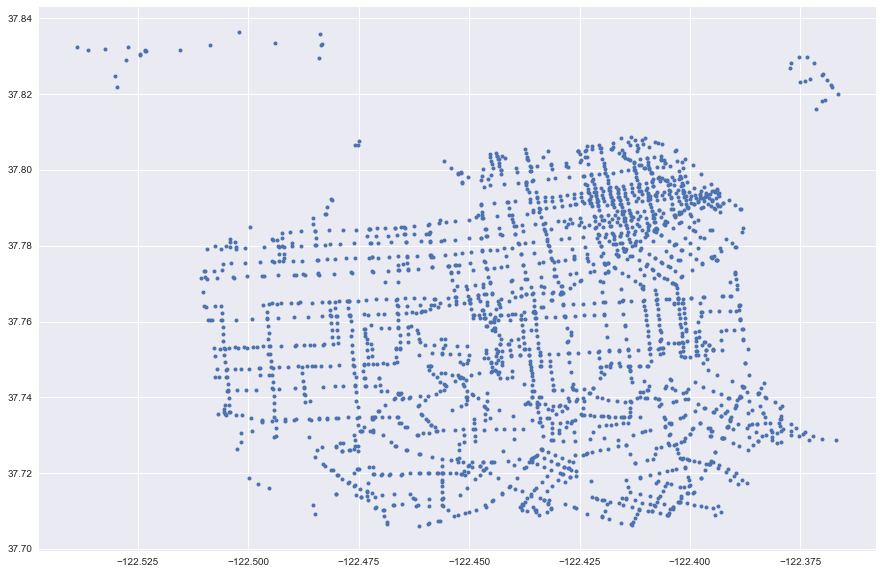

In [10]:
sns.set()
plt.figure(figsize=(15,10))
plt.plot(df['stop_lon'], df['stop_lat'], 'o', markersize=4)
plt.show()

In [11]:
df = df[['stop_lat','stop_lon','stop_name','agency_name']]

In [12]:
df.head()

,stop_lat,stop_lon,stop_name,agency_name
0,37.792357,-122.421010,Clay St & Polk St,Muni
1,37.793826,-122.409591,Clay St & Powell St,Muni
2,37.793653,-122.410823,Clay St & Mason St,Muni
3,37.794682,-122.402770,Clay St & Montgomery St,Muni
4,37.792526,-122.419589,Clay St & Larkin St,Muni


>### Visualizing the Coordinates Caltrain

In [13]:
caltrain = pd.read_csv('data/CT-GTFS/stops.txt')
caltrain.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,platform_code,wheelchair_boarding
0,70011,70011,San Francisco Caltrain,NaN,37.776390,-122.394992,1.0,NaN,0,NaN,NB,1
1,70012,70012,San Francisco Caltrain,NaN,37.776348,-122.394935,1.0,NaN,0,NaN,SB,1
2,70021,70021,22nd St Caltrain,NaN,37.757599,-122.391880,1.0,NaN,0,NaN,NB,2
3,70022,70022,22nd St Caltrain,NaN,37.757583,-122.392404,1.0,NaN,0,NaN,SB,2
4,70031,70031,Bayshore Caltrain,NaN,37.709537,-122.401586,1.0,NaN,0,NaN,NB,1


In [14]:
caltrain = caltrain[caltrain['platform_code'] == 'NB'][['stop_lat','stop_lon','stop_name']]

In [15]:
caltrain['agency_name'] = 'Caltrain'

In [16]:
caltrain.head()

,stop_lat,stop_lon,stop_name,agency_name
0,37.776390,-122.394992,San Francisco Caltrain,Caltrain
2,37.757599,-122.391880,22nd St Caltrain,Caltrain
4,37.709537,-122.401586,Bayshore Caltrain,Caltrain
6,37.655890,-122.404870,So. San Francisco Caltrain Station,Caltrain
8,37.631128,-122.411968,San Bruno Caltrain,Caltrain


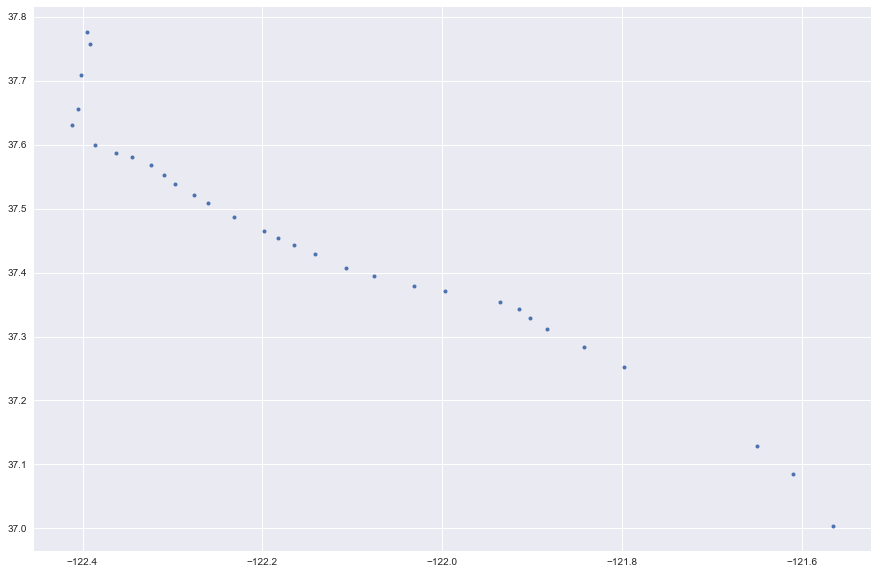

In [17]:
sns.set()
plt.figure(figsize=(15,10))
plt.plot(caltrain['stop_lon'], caltrain['stop_lat'], 'o', markersize=4)
plt.show()

>### Visualizing the Coordinates Bart

In [18]:
bart = pd.read_csv('data/GTFS-20180212_v2/stops.txt')
bart.head()

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,12TH,12th St. Oakland City Center,NaN,37.803768,-122.271450,12TH,http://www.bart.gov/stations/12TH/,0,NaN,NaN,1
1,16TH,16th St. Mission,NaN,37.765062,-122.419694,16TH,http://www.bart.gov/stations/16TH/,0,NaN,NaN,1
2,19TH,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1
3,19TH_N,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1
4,24TH,24th St. Mission,NaN,37.752470,-122.418143,24TH,http://www.bart.gov/stations/24TH/,0,NaN,NaN,1


In [19]:
bart['agency_name'] = 'Bart'

In [20]:
bart[bart['stop_name'].duplicated()]

,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,agency_name
3,19TH_N,19th St. Oakland,NaN,37.808350,-122.268602,19TH,http://www.bart.gov/stations/19TH/,0,NaN,NaN,1,Bart
26,MCAR_S,MacArthur,NaN,37.829065,-122.267040,MCAR,http://www.bart.gov/stations/MCAR/,0,NaN,NaN,1,Bart


In [21]:
bart = bart[~bart['stop_name'].duplicated()]

In [22]:
bart = bart[['stop_lat','stop_lon','stop_name','agency_name']]

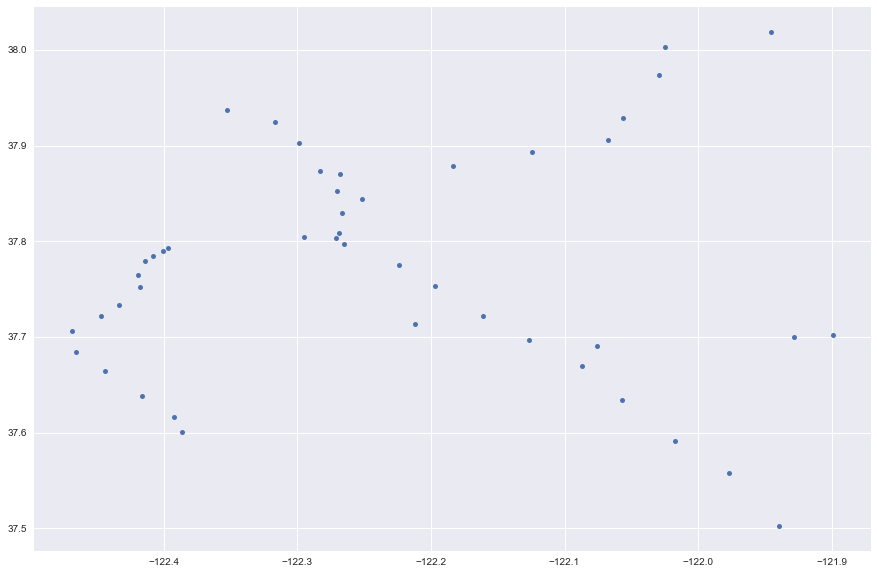

In [23]:
sns.set()
plt.figure(figsize=(15,10))
plt.plot(bart['stop_lon'], bart['stop_lat'], 'o', markersize=5)
plt.show()

In [24]:
df = df.append(caltrain, ignore_index=True)

In [25]:
df = df.append(bart, ignore_index=True)

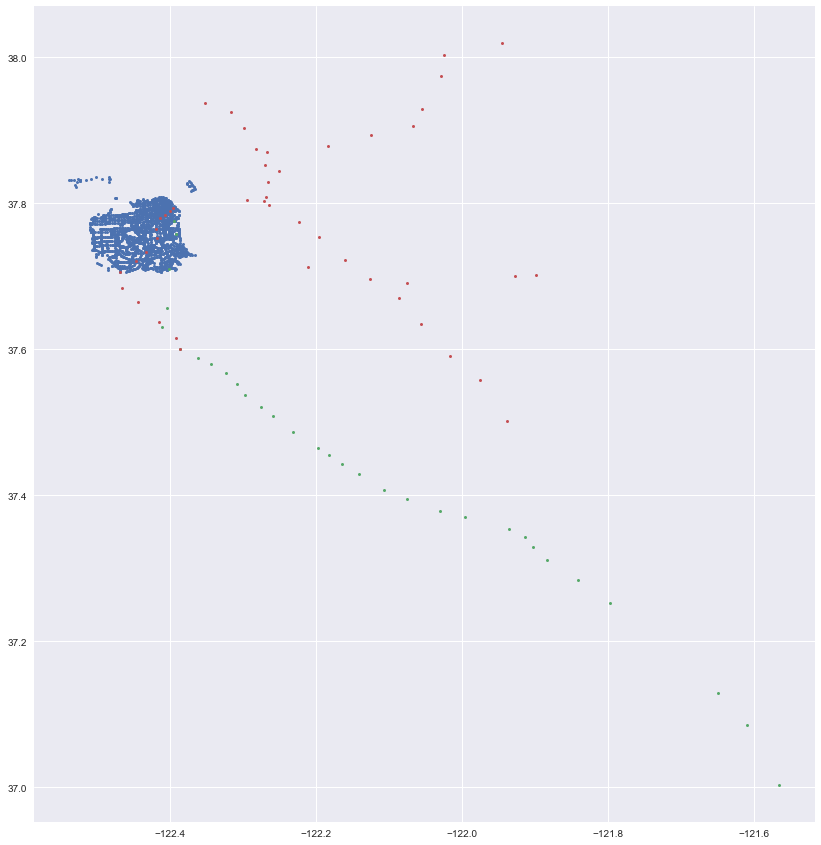

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect(1)

muni_x = df[df['agency_name'] == 'Muni']['stop_lon']
muni_y = df[df['agency_name'] == 'Muni']['stop_lat']
caltrain_x = df[df['agency_name'] == 'Caltrain']['stop_lon']
caltrain_y = df[df['agency_name'] == 'Caltrain']['stop_lat']
bart_x = df[df['agency_name'] == 'Bart']['stop_lon']
bart_y = df[df['agency_name'] == 'Bart']['stop_lat']

ax.plot(muni_x, muni_y, 'o', markersize=3)
ax.plot(caltrain_x, caltrain_y, 'o', markersize=3)
ax.plot(bart_x, bart_y, 'o', markersize=3)
plt.show()

>### Solution for Finding Closest Public Transit

> NearestNeighbors implements unsupervised nearest neighbors learning. It acts as a uniform interface to three different nearest neighbors algorithms: BallTree, KDTree, and a brute-force algorithm.

> ### Common NearestNeighbors Distance Functions
> These distance functions can be used with NearestNeighbors. Minkowski is default distance function.
>
> ### Euclidean  
> $\sqrt{\sum\limits_{i=1}^k(x_i - y_i)^2}$
>
> ### Manhattan 
> $\sum\limits_{i=1}^k \left| x_i - y_i \right|$
>
> ### Minkowski
> $\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$

>### Training and Fitting the Model

In [27]:
lat = df['stop_lat'].values.reshape(-1, 1)
lon = df['stop_lon'].values.reshape(-1, 1)
X = np.concatenate((lat, lon), axis=1)
neigh = NearestNeighbors()
neigh.fit(X) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [28]:
def find_nearest_transit(coordinates):
    distance = neigh.kneighbors([coordinates])[0][0]
    indices = neigh.kneighbors([coordinates])[1]
    for index in indices:
        op = df.loc[index][['stop_name','agency_name']]
    op.reset_index(drop=True, inplace=True)
    op['distance'] = distance
    return op

In [29]:
coordinates = [37.773196, -122.405386]

In [30]:
find_nearest_transit(coordinates)

,stop_name,agency_name,distance
0,7th St & Bryant St,Muni,0.001442
1,Bryant St & 7th St,Muni,0.001485
2,8th St & Brannan St,Muni,0.001721
3,8th St & Bryant St,Muni,0.001862
4,Brannan St & 8th ST,Muni,0.001880


In [31]:
Zuckerberg_General_Hospital = [37.755195, -122.405083]

In [32]:
find_nearest_transit(Zuckerberg_General_Hospital)

,stop_name,agency_name,distance
0,23rd St & Utah St,Muni,0.000788
1,Potrero Ave At SF General Hospital,Muni,0.001406
2,Sf General Hospital,Muni,0.001584
3,23rd St & Vermont St,Muni,0.001658
4,Potrero Ave & 23rd St,Muni,0.001682


In [33]:
UCSF_Childrens_Hospital = [37.764932, -122.389720]

In [34]:
find_nearest_transit(UCSF_Childrens_Hospital)

,stop_name,agency_name,distance
0,Third St & Mariposa St.,Muni,0.001082
1,Third St & Mariposa St,Muni,0.001084
2,Third Street & Mariposa St,Muni,0.001101
3,Tennessee St & 18th St,Muni,0.002033
4,16th St & 4th St,Muni,0.002088


In [35]:
Westfield_SF_Mall = [37.784304, -122.407562]

In [36]:
find_nearest_transit(Westfield_SF_Mall)

,stop_name,agency_name,distance
0,Metro Powell Station/Downtown,Muni,0.000169
1,Market St & Powell St,Muni,0.000171
2,Metro Powell Station/Outbound,Muni,0.000260
3,Powell St & Market St,Muni,0.000399
4,Powell St.,Bart,0.000445
